<a href="https://colab.research.google.com/github/klausgottlieb/crut-monte-carlo-replication/blob/main/notebook_03_longevity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 03 — Longevity
## *When Do Charitable Remainder Unitrusts Outperform? A Monte Carlo Analysis*
### Klaus Gottlieb, JD, MS, MBA — Wealth Care Lawyer, Cayucos, CA

---

## Purpose

Longevity ranked **#2 of 12 parameters** in the OAT sensitivity analysis (Notebook 01), with a 39 percentage-point range in win probability across the tested range (-5 yr to +10 yr adjustment). It is exceeded only by expected return μ (55pp). This notebook examines longevity in depth.

Longevity affects CRUT performance through two distinct mechanisms that operate in opposite directions:

**Mechanism 1 — Horizon length (favors longer life):**
A longer trust horizon means more annual distributions, more years of tax-deferred compounding inside the trust, and a longer period over which the benchmark suffers annual turnover drag. Longer life is generally favorable to the CRUT on a distribution-income basis.

**Mechanism 2 — Deduction size (ambiguous effect of age):**
The charitable deduction is computed at inception using IRS actuarial tables. Younger donors have a larger expected trust horizon, which means a larger payout factor, which *reduces* the remainder factor R and thus the deduction. Older donors have a smaller expected horizon, higher R, and larger deduction — but fewer years to benefit from distributions. These two effects partially offset each other, producing a non-monotonic relationship between age and CRUT attractiveness.

**Mechanism 3 — Actual vs. actuarial life (the longevity adjustment):**
The IRS actuarial tables describe population averages. Individual donors may live materially longer or shorter than these averages. This notebook models the economic consequences of that divergence.

---

## A Note on Adverse Selection and Longevity Assumptions

A well-documented phenomenon in annuity and life income planning is that individuals who enter into arrangements that pay income for life tend to be healthier than the general population at the same age. This occurs because:

- Individuals in poor health are less likely to enter into irrevocable life-income arrangements
- Planners appropriately counsel clients with shortened life expectancy against CRUTs
- The decision to make an irrevocable multi-decade commitment is itself a signal of perceived health

This notebook models longevity adjustments as a **planning scenario analysis**, not as a claim about population characteristics. The question being asked is: *given that a client enters a CRUT at the baseline ages, how does win probability change if they live longer or shorter than the IRS tables predict?*

This framing is appropriate for two reasons. First, it is honest — the simulation does not claim to predict who will or will not enter a CRUT. Second, it is clinically useful — a planner advising a healthy 65-year-old client whose family history suggests above-average longevity should understand how that changes the CRUT's economics.

The analysis is presented neutrally, with equal attention to shorter-than-expected and longer-than-expected scenarios.

---

## Sections and Figures

**Section 1 — Longevity Adjustment Sweep**
Win probability as a function of longevity adjustment (-10yr to +15yr) at four turnover levels. Replicates and extends the OAT finding.

**Section 2 — Starting Age Sweep**
Win probability as a function of starting ages (younger of the two donors aged 45 through 75, gap held constant at 2 years). Shows how age at contribution interacts with CRUT attractiveness.

**Section 3 — Single Life vs. Two Life**
At matched ages, how does adding a second beneficiary change win probability? Two Life extends the horizon and reduces the deduction — the net effect is examined here.

**Section 4 — Longevity × Return Interaction**
A 2D heatmap showing win probability across combinations of longevity adjustment and expected return μ. Longevity (#2) and return (#1) are the two dominant parameters — are their effects additive or do they interact?

**Section 5 — Planning Scenarios: Four Archetypal Clients**
A practical synthesis showing four representative client profiles and their CRUT win probabilities under all longevity and turnover assumptions.

---

## Ground Truth from Prior Notebooks

| Quantity | Value | Source |
|---|---|---|
| Baseline win probability (20% turnover, liq) | see NB00 output | NB00 |
| Charitable deduction | $126,389 | NB00 |
| Remainder factor | 0.1264 | NB00 |
| PV of tax benefit | $58,518 | NB00 |
| IRS actuarial horizon | 32.8 yr | NB00 |
| Simulation horizon (rounded) | 33 yr | NB00 |
| Longevity OAT range | 39.0 pp | NB01 |
| Longevity OAT rank | #2 of 12 | NB01 |

---

In [1]:
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install',
                       'numpy', 'matplotlib', 'scipy', '--quiet'])
print('Dependencies confirmed.')

Dependencies confirmed.


In [2]:
from dataclasses import dataclass, replace
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.rcParams.update({
    'figure.dpi': 120,
    'font.family': 'sans-serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.facecolor': 'white',
})

TURNOVER_LEVELS = [0.00, 0.20, 0.40, 0.60]
TURNOVER_LABELS = ['0% (buy-and-hold)', '20% (moderate)', '40% (active)', '60% (original baseline)']
TURNOVER_COLORS = ['#08306b', '#2171b5', '#fd8d3c', '#d73027']

print('Imports complete.')

Imports complete.


In [3]:
# =============================================================================
# COMPLETE SIMULATION ENGINE (self-contained)
# =============================================================================

IRS_LIFE_EXPECTANCY = {
    35: 48.3, 40: 43.6, 45: 38.9, 50: 34.2, 55: 29.6,
    60: 25.2, 61: 24.4, 62: 23.5, 63: 22.7, 64: 21.8,
    65: 21.0, 66: 20.2, 67: 19.4, 68: 18.6, 69: 17.8,
    70: 17.0, 71: 16.3, 72: 15.5, 73: 14.8, 74: 14.1,
    75: 13.4, 76: 12.7, 77: 12.1, 78: 11.4, 79: 10.8,
    80: 10.2, 85: 7.3,  90: 5.0
}

def get_life_expectancy(age):
    if age in IRS_LIFE_EXPECTANCY:
        return IRS_LIFE_EXPECTANCY[age]
    ages = sorted(IRS_LIFE_EXPECTANCY.keys())
    for i in range(len(ages) - 1):
        if ages[i] < age < ages[i+1]:
            a1, a2 = ages[i], ages[i+1]
            return (IRS_LIFE_EXPECTANCY[a1]
                    + (IRS_LIFE_EXPECTANCY[a2] - IRS_LIFE_EXPECTANCY[a1])
                    * (age - a1) / (a2 - a1))
    raise ValueError(f'Age {age} out of range')

def get_joint_life_expectancy(age1, age2):
    e1, e2 = get_life_expectancy(age1), get_life_expectancy(age2)
    return e1 + e2 - 1.0 / (1.0/e1 + 1.0/e2)

def compute_deduction(fmv, payout_rate, rate_7520, life_type,
                      age1=65, age2=None, term_years=20,
                      freq=4, lag_months=0, longevity_adj=0):
    """
    Compute CRUT charitable deduction using IRS Reg. 1.664-4 method.
    Table F adjustment: rate_7520 / (freq * ((1+rate_7520)^(1/freq) - 1))
    For 5% rate quarterly: table_f ~ 1.0186, adjusted payout ~ 6.11%.
    R must be >= 10% (IRC 664 charitable remainder requirement).

    longevity_adj: years added to (or subtracted from) the IRS actuarial
    horizon for the simulation only. The deduction is computed at the IRS
    duration without adjustment — longevity_adj affects only how long
    the simulation runs, not the deduction amount. This correctly models
    the scenario where a donor lives longer or shorter than the IRS tables
    predict: the deduction was fixed at inception, but the actual trust
    period extends beyond (or falls short of) the actuarial expectancy.
    """
    i, p = rate_7520, payout_rate
    table_f         = i / (freq * ((1 + i) ** (1/freq) - 1))
    adjusted_payout = p * table_f
    if life_type == 'Term of Years':
        irs_duration = float(term_years)
    elif life_type == 'Single Life':
        irs_duration = get_life_expectancy(age1)
    else:
        irs_duration = get_joint_life_expectancy(age1, age2)
    R = max(0.0, min(1.0, (1 - adjusted_payout) ** irs_duration))
    return {
        'deduction':      fmv * R,
        'remainder_factor': R,
        'compliance':     R >= 0.10,
        'irs_duration':   irs_duration,
        'sim_horizon':    irs_duration + longevity_adj,
    }

def generate_return_paths(mu, sigma, n_years, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed)
    mu_log    = np.log(1 + mu) - 0.5 * (sigma / (1 + mu)) ** 2
    sigma_log = sigma / (1 + mu)
    return np.exp(np.random.normal(mu_log, sigma_log, size=(n_paths, n_years)))

@dataclass
class ScenarioParams:
    fmv:                float        = 1_000_000
    basis_pct:          float        = 0.20
    agi:                float        = 500_000
    payout_rate:        float        = 0.06
    life_type:          str          = 'Two Life'
    age1:               int          = 63
    age2:               Optional[int]= 65
    term_years:         int          = 20
    freq:               int          = 4
    lag_months:         int          = 0
    longevity_adj:      int          = 0
    rate_7520:          float        = 0.05
    pv_rate:            float        = 0.05
    fed_ordinary:       float        = 0.37
    fed_ltcg:           float        = 0.20
    niit:               float        = 0.038
    state_rate:         float        = 0.093
    agi_limit_pct:      float        = 0.30
    carryforward_years: int          = 5
    trust_fee:          float        = 0.01
    bench_fee:          float        = 0.01
    turnover:           float        = 0.20
    mu:                 float        = 0.07
    sigma:              float        = 0.12
    n_paths:            int          = 2000
    seed:               int          = 42

def run_simulation(params):
    """
    Run paired-path Monte Carlo CRUT vs. hold-liquidation benchmark.

    Longevity note:
    The longevity_adj parameter extends or shortens the simulation horizon
    beyond the IRS actuarial duration. The charitable deduction is computed
    at the IRS duration (no adjustment) — it was fixed at trust inception.
    Only the simulation horizon changes. This means:
    - Positive longevity_adj: donor lives longer than IRS tables predict.
      More distributions are paid; the CRUT corpus has more time to compound;
      the benchmark has more time to accumulate annual turnover drag.
      These effects generally favor the CRUT.
    - Negative longevity_adj: donor dies earlier than predicted.
      Fewer distributions; less compounding; the benchmark suffers less drag.
      These effects generally favor the benchmark.
    """
    p = params
    tau_ord = p.fed_ordinary + p.state_rate
    tau_cg  = p.fed_ltcg + p.niit + p.state_rate

    ded_res = compute_deduction(
        fmv=p.fmv, payout_rate=p.payout_rate, rate_7520=p.rate_7520,
        life_type=p.life_type, age1=p.age1, age2=p.age2,
        term_years=p.term_years, freq=p.freq, lag_months=p.lag_months,
        longevity_adj=p.longevity_adj,
    )
    T           = max(1, int(round(ded_res['sim_horizon'])))
    deduction   = ded_res['deduction']
    annual_limit= p.agi * p.agi_limit_pct
    remaining   = deduction
    pv_tax      = 0.0
    for yr in range(p.carryforward_years + 1):
        usable    = min(remaining, annual_limit)
        if usable <= 0: break
        pv_tax   += usable * tau_ord / (1 + p.pv_rate) ** yr
        remaining -= usable

    returns = generate_return_paths(p.mu, p.sigma, T, p.n_paths, seed=p.seed)

    # CRUT
    crut_v = np.full(p.n_paths, p.fmv)
    dists  = np.zeros((p.n_paths, T))
    for t in range(T):
        v          = crut_v * (1 - p.trust_fee) * returns[:, t]
        d          = v * p.payout_rate
        dists[:, t]= d * (1 - tau_ord)
        crut_v     = np.maximum(0, v - d)
    disc        = np.array([(1 + p.pv_rate) ** -(t+1) for t in range(T)])
    crut_wealth = (dists * disc).sum(axis=1) + pv_tax

    # Benchmark (hold-liquidation)
    bench_v    = np.full(p.n_paths, p.fmv)
    bench_basis= p.fmv * p.basis_pct
    for t in range(T):
        b          = bench_v * (1 - p.bench_fee) * returns[:, t]
        gain       = np.maximum(0, b - bench_basis)
        tax_drag   = p.turnover * gain * tau_cg
        bench_v    = np.maximum(0, b - tax_drag)
        bench_basis= bench_basis + p.turnover * gain * (1 - tau_cg)
    term_gain    = np.maximum(0, bench_v - bench_basis)
    bench_term   = bench_v - term_gain * tau_cg
    bench_wealth = bench_term / (1 + p.pv_rate) ** T

    delta = crut_wealth - bench_wealth
    return {
        'win_prob':     float(np.mean(delta > 0)),
        'median_delta': float(np.median(delta)),
        'delta_wealth': delta,
        'pv_tax':       pv_tax,
        'deduction':    deduction,
        'irs_duration': ded_res['irs_duration'],
        'T':            T,
        'params':       p,
    }

def bootstrap_ci(data, stat_fn=None, n_boot=1000, ci=0.95, seed=0):
    if stat_fn is None:
        stat_fn = lambda x: np.mean(x > 0)
    rng  = np.random.RandomState(seed)
    n    = len(data)
    boot = [stat_fn(rng.choice(data, size=n, replace=True)) for _ in range(n_boot)]
    alpha = 1 - ci
    return (float(np.percentile(boot, 100*alpha/2)),
            float(np.percentile(boot, 100*(1-alpha/2))))

# Verify baseline
baseline = ScenarioParams()
r0 = run_simulation(baseline)
print(f'Baseline (Two Life 63/65, 20% turnover, 0yr adj):')
print(f'  Win probability:  {r0["win_prob"]:.1%}')
print(f'  Median delta:     ${r0["median_delta"]:,.0f}')
print(f'  Deduction:        ${r0["deduction"]:,.0f}')
print(f'  PV tax benefit:   ${r0["pv_tax"]:,.0f}')
print(f'  IRS duration:     {r0["irs_duration"]:.1f} yr')
print(f'  Sim horizon:      {r0["T"]} yr')
print()
print('Engine ready.')

Baseline (Two Life 63/65, 20% turnover, 0yr adj):
  Win probability:  54.3%
  Median delta:     $19,397
  Deduction:        $126,456
  PV tax benefit:   $58,549
  IRS duration:     32.8 yr
  Sim horizon:      33 yr

Engine ready.


---
## Section 1 — Longevity Adjustment Sweep

### Figure 1: Win Probability vs. Longevity Adjustment

This figure sweeps the longevity adjustment from **-10 years** to **+15 years** relative to the IRS actuarial expectancy for the Two Life 63/65 baseline (IRS duration ≈ 32.8 years). The four lines show how this relationship changes across the four turnover assumptions.

**Important methodological note:** The charitable deduction is computed at the IRS actuarial duration without adjustment in every simulation. Longevity adjustment affects only the simulation horizon — the number of years the trust actually runs. The deduction was fixed at inception and cannot be retroactively changed based on actual longevity. This correctly models the real-world situation:

- If the donor lives longer than the IRS tables predict, the trust continues to pay distributions for additional years. The deduction benefit is unchanged; the extra years of distributions and compounding favor the CRUT.
- If the donor dies earlier, the trust terminates early. Fewer distributions are paid; the deduction benefit is unchanged; the benchmark has fewer years of turnover drag.

**Economic interpretation of the slope:**
The positive slope (longer life → higher win probability) reflects the compounding asymmetry between the CRUT and the benchmark. In each additional year the trust runs, the CRUT distributes income while the benchmark's unrealized gains continue to accumulate deferred tax liability. The CRUT is structurally short-horizon in a way that makes it more attractive when horizons are long.

Running longevity adjustment sweep...
  26 adjustments x 4 turnover levels = 104 simulations
  0% (buy-and-hold): done
  20% (moderate): done
  40% (active): done
  60% (original baseline): done


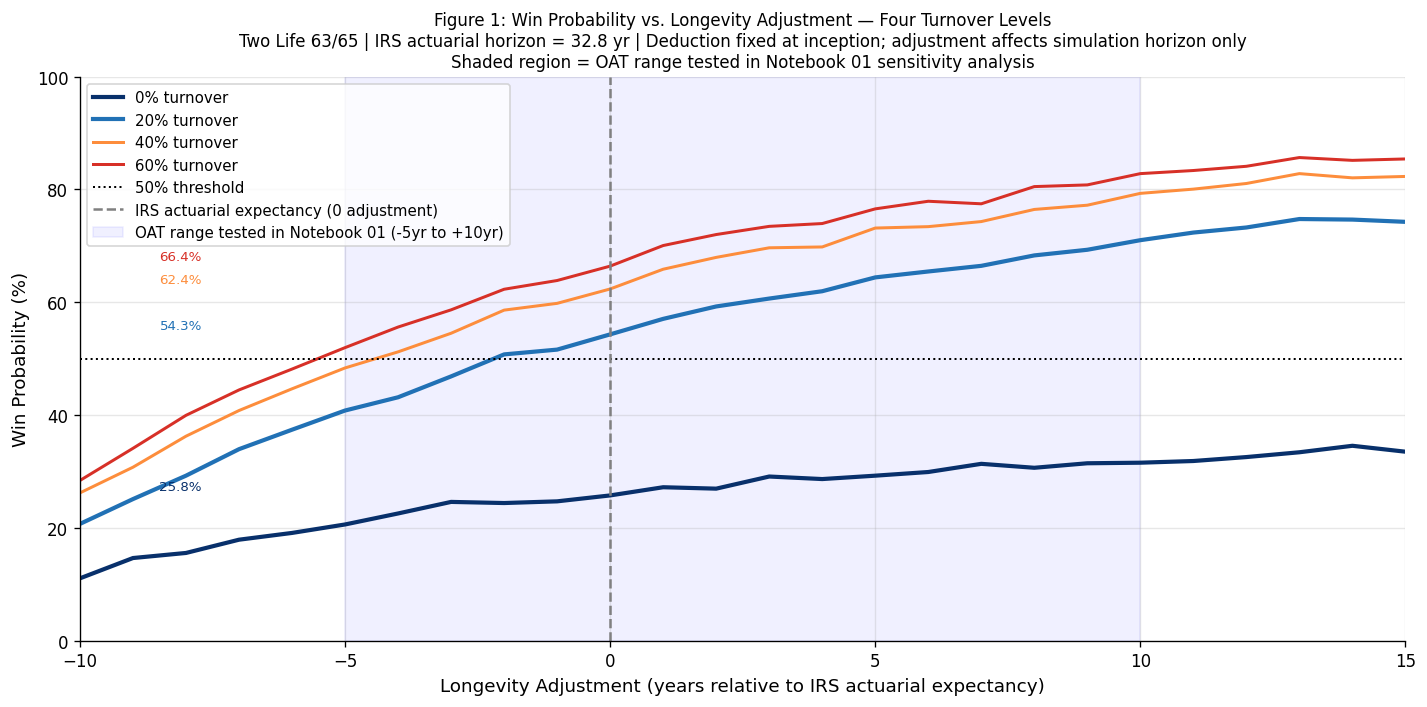

Figure 1 saved.

Win probability at adj=0 (IRS expectancy):
  0% (buy-and-hold): 25.8%
  20% (moderate): 54.3%
  40% (active): 62.4%
  60% (original baseline): 66.4%


In [4]:
# --- Figure 1: Win probability vs. longevity adjustment ---

longevity_adjs = np.arange(-10, 16, 1)   # -10yr to +15yr in 1yr steps

print('Running longevity adjustment sweep...')
print(f'  {len(longevity_adjs)} adjustments x {len(TURNOVER_LEVELS)} turnover levels = '
      f'{len(longevity_adjs)*len(TURNOVER_LEVELS)} simulations')

longevity_results = {}   # turnover -> wp array
for tv, tv_label in zip(TURNOVER_LEVELS, TURNOVER_LABELS):
    wp_arr = []
    for adj in longevity_adjs:
        r = run_simulation(replace(baseline, turnover=tv, longevity_adj=int(adj)))
        wp_arr.append(r['win_prob'])
    longevity_results[tv] = np.array(wp_arr)
    print(f'  {tv_label}: done')

# IRS baseline horizon
irs_dur = run_simulation(baseline)['irs_duration']
idx_zero = np.argmin(np.abs(longevity_adjs - 0))

fig, ax = plt.subplots(figsize=(12, 6))

for tv, color, tv_label, lw in zip(
        TURNOVER_LEVELS, TURNOVER_COLORS, TURNOVER_LABELS,
        [2.5, 2.5, 1.8, 1.8]):
    wp = longevity_results[tv]
    ax.plot(longevity_adjs, wp * 100, color=color, lw=lw,
            label=f'{tv*100:.0f}% turnover')

ax.axhline(50,  color='black', lw=1.2, ls=':', label='50% threshold')
ax.axvline(0,   color='gray',  lw=1.5, ls='--', label='IRS actuarial expectancy (0 adjustment)')

# Annotate the OAT range (-5yr to +10yr) used in Notebook 01
ax.axvspan(-5, 10, alpha=0.06, color='blue',
           label='OAT range tested in Notebook 01 (-5yr to +10yr)')

# Annotate at adj=0 for each turnover
for tv, color in zip(TURNOVER_LEVELS, TURNOVER_COLORS):
    wp_0 = longevity_results[tv][idx_zero] * 100
    ax.annotate(f'{wp_0:.1f}%',
                xy=(0, wp_0), xytext=(-8.5, wp_0 + 1),
                fontsize=8, color=color)

ax.set_xlabel('Longevity Adjustment (years relative to IRS actuarial expectancy)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title(
    f'Figure 1: Win Probability vs. Longevity Adjustment — Four Turnover Levels\n'
    f'Two Life 63/65 | IRS actuarial horizon = {irs_dur:.1f} yr | '
    f'Deduction fixed at inception; adjustment affects simulation horizon only\n'
    f'Shaded region = OAT range tested in Notebook 01 sensitivity analysis',
    fontsize=10
)
ax.legend(fontsize=9, loc='upper left')
ax.set_xlim(-10, 15)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig('fig1_longevity_sweep.png', bbox_inches='tight', dpi=150)
plt.show()

print('Figure 1 saved.')
print()
print('Win probability at adj=0 (IRS expectancy):')
for tv, tv_label in zip(TURNOVER_LEVELS, TURNOVER_LABELS):
    print(f'  {tv_label}: {longevity_results[tv][idx_zero]:.1%}')

---
## Section 2 — Starting Age Sweep

### Figures 2–3: Win Probability vs. Starting Age

This section sweeps the starting ages of the two beneficiaries. The age gap is held constant at **2 years** (consistent with the baseline: donor 1 age 63, donor 2 age 65). The younger beneficiary ranges from **age 45 to age 75**.

**Two competing effects govern the shape of this curve:**

1. **Longer horizon at younger ages** favors the CRUT: more years of distributions, more compounding, more annual benchmark drag.

2. **Smaller deduction at younger ages** disfavors the CRUT: younger donors have a higher payout factor (more distributions expected), which lowers the remainder factor R. At very young ages the 10% test may constrain the payout rate or fail entirely.

The curve is therefore not monotonic. There is typically an optimal age range where the horizon is long enough to generate substantial distribution value, but the deduction is not yet severely compressed by youth.

**Figure 2** shows win probability vs. starting age at four turnover levels.
**Figure 3** shows the deduction size and IRS actuarial horizon as a function of age — the two underlying drivers — so the win probability curve in Figure 2 can be interpreted mechanistically.

Running starting age sweep...
  31 age pairs x 4 turnover levels = 124 simulations
  0% turnover: done
  20% turnover: done
  40% turnover: done
  60% turnover: done


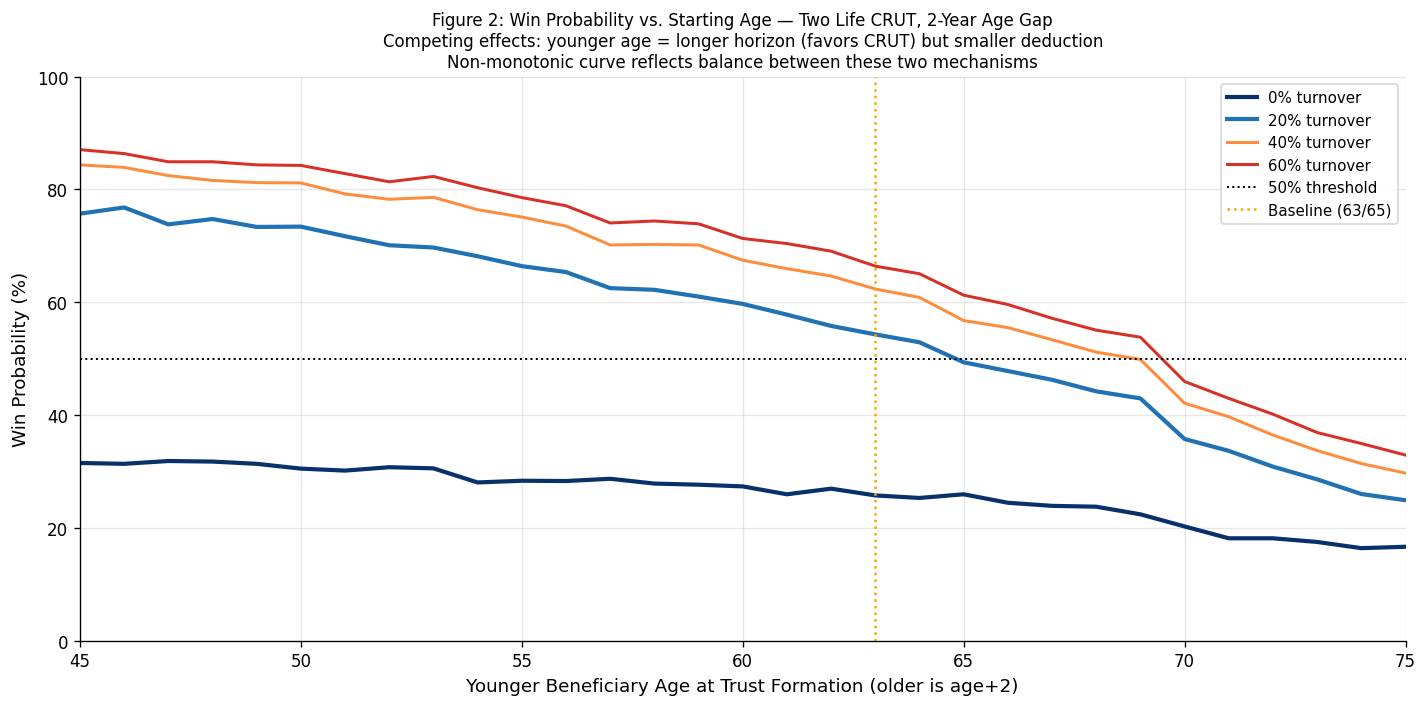

Figure 2 saved.


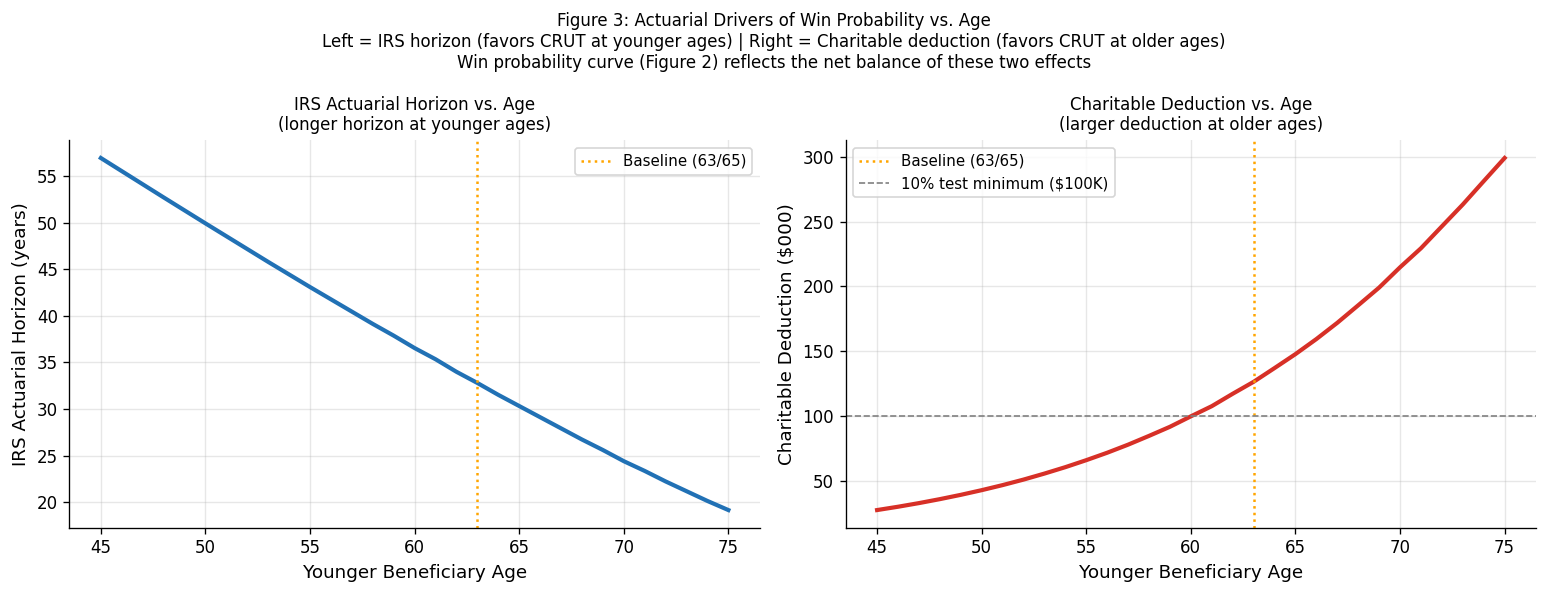

Figure 3 saved.

Optimal starting age (younger beneficiary) by turnover:
  0% (buy-and-hold): age 47/49 (win prob = 31.9%)
  20% (moderate): age 46/48 (win prob = 76.8%)
  40% (active): age 45/47 (win prob = 84.4%)
  60% (original baseline): age 45/47 (win prob = 87.1%)


In [5]:
# --- Figures 2-3: Starting age sweep ---
# Younger donor age 45-75; older donor always 2 years senior.
# Age gap constant at 2 years.

younger_ages = np.arange(45, 76, 1)   # 45 to 75

print('Running starting age sweep...')
print(f'  {len(younger_ages)} age pairs x {len(TURNOVER_LEVELS)} turnover levels = '
      f'{len(younger_ages)*len(TURNOVER_LEVELS)} simulations')

age_wp     = {}   # turnover -> wp array
irs_durs   = []   # IRS actuarial duration at each age pair
deductions = []   # deduction at each age pair

for tv in TURNOVER_LEVELS:
    wp_arr = []
    for age in younger_ages:
        p = replace(baseline, age1=int(age), age2=int(age+2), turnover=tv)
        r = run_simulation(p)
        wp_arr.append(r['win_prob'])
        if tv == TURNOVER_LEVELS[0]:   # record actuarial data once
            irs_durs.append(r['irs_duration'])
            deductions.append(r['deduction'])
    age_wp[tv] = np.array(wp_arr)
    print(f'  {tv*100:.0f}% turnover: done')

irs_durs   = np.array(irs_durs)
deductions = np.array(deductions)

# Figure 2: Win probability vs. starting age
fig, ax = plt.subplots(figsize=(12, 6))
for tv, color, tv_label, lw in zip(
        TURNOVER_LEVELS, TURNOVER_COLORS, TURNOVER_LABELS,
        [2.5, 2.5, 1.8, 1.8]):
    ax.plot(younger_ages, age_wp[tv] * 100,
            color=color, lw=lw, label=f'{tv*100:.0f}% turnover')

ax.axhline(50, color='black', lw=1.2, ls=':', label='50% threshold')
ax.axvline(63, color='orange', lw=1.5, ls=':', label='Baseline (63/65)')

ax.set_xlabel('Younger Beneficiary Age at Trust Formation (older is age+2)', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title(
    'Figure 2: Win Probability vs. Starting Age — Two Life CRUT, 2-Year Age Gap\n'
    'Competing effects: younger age = longer horizon (favors CRUT) but smaller deduction\n'
    'Non-monotonic curve reflects balance between these two mechanisms',
    fontsize=10
)
ax.legend(fontsize=9)
ax.set_xlim(45, 75)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig('fig2_age_sweep_wp.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 2 saved.')

# Figure 3: Actuarial drivers — IRS duration and deduction vs. age
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(younger_ages, irs_durs, color='#2171b5', lw=2.5)
axes[0].axvline(63, color='orange', lw=1.5, ls=':', label='Baseline (63/65)')
axes[0].set_xlabel('Younger Beneficiary Age', fontsize=11)
axes[0].set_ylabel('IRS Actuarial Horizon (years)', fontsize=11)
axes[0].set_title('IRS Actuarial Horizon vs. Age\n(longer horizon at younger ages)', fontsize=10)
axes[0].legend(fontsize=9)

axes[1].plot(younger_ages, deductions/1000, color='#d73027', lw=2.5)
axes[1].axvline(63, color='orange', lw=1.5, ls=':', label='Baseline (63/65)')
axes[1].axhline(100, color='gray', lw=1, ls='--', label='10% test minimum ($100K)')
axes[1].set_xlabel('Younger Beneficiary Age', fontsize=11)
axes[1].set_ylabel('Charitable Deduction ($000)', fontsize=11)
axes[1].set_title('Charitable Deduction vs. Age\n(larger deduction at older ages)', fontsize=10)
axes[1].legend(fontsize=9)

fig.suptitle(
    'Figure 3: Actuarial Drivers of Win Probability vs. Age\n'
    'Left = IRS horizon (favors CRUT at younger ages) | '
    'Right = Charitable deduction (favors CRUT at older ages)\n'
    'Win probability curve (Figure 2) reflects the net balance of these two effects',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig3_age_drivers.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 3 saved.')

# Find optimal age at each turnover
print()
print('Optimal starting age (younger beneficiary) by turnover:')
for tv, tv_label in zip(TURNOVER_LEVELS, TURNOVER_LABELS):
    opt_idx = np.argmax(age_wp[tv])
    print(f'  {tv_label}: age {younger_ages[opt_idx]}/{younger_ages[opt_idx]+2} '
          f'(win prob = {age_wp[tv][opt_idx]:.1%})')

---
## Section 3 — Single Life vs. Two Life

### Figure 4: Single Life vs. Two Life Comparison

The baseline scenario uses a Two Life CRUT with beneficiaries aged 63 and 65. This section compares Single Life and Two Life CRUTs at the same ages across the full age range.

**The mechanics of the comparison:**

Adding a second beneficiary extends the expected trust horizon — the trust continues until the *later* death, not the earlier. This extension increases the total distributions and the benchmark turnover drag, generally favoring the CRUT. However, the IRS actuarial tables compute a *joint* life expectancy that is substantially longer than either individual expectancy, which reduces the remainder factor R and shrinks the deduction.

**The net effect is not obvious without simulation.** For most ages and turnover levels, the horizon extension benefit outweighs the deduction compression cost — but the margin varies with age and is the subject of this figure.

**Planning implication:** A married couple considering a Two Life CRUT can use this figure to understand how much they give up in deduction relative to a Single Life CRUT on the older spouse alone, and whether the extended income horizon compensates.

Running Single Life vs. Two Life comparison...
Done.


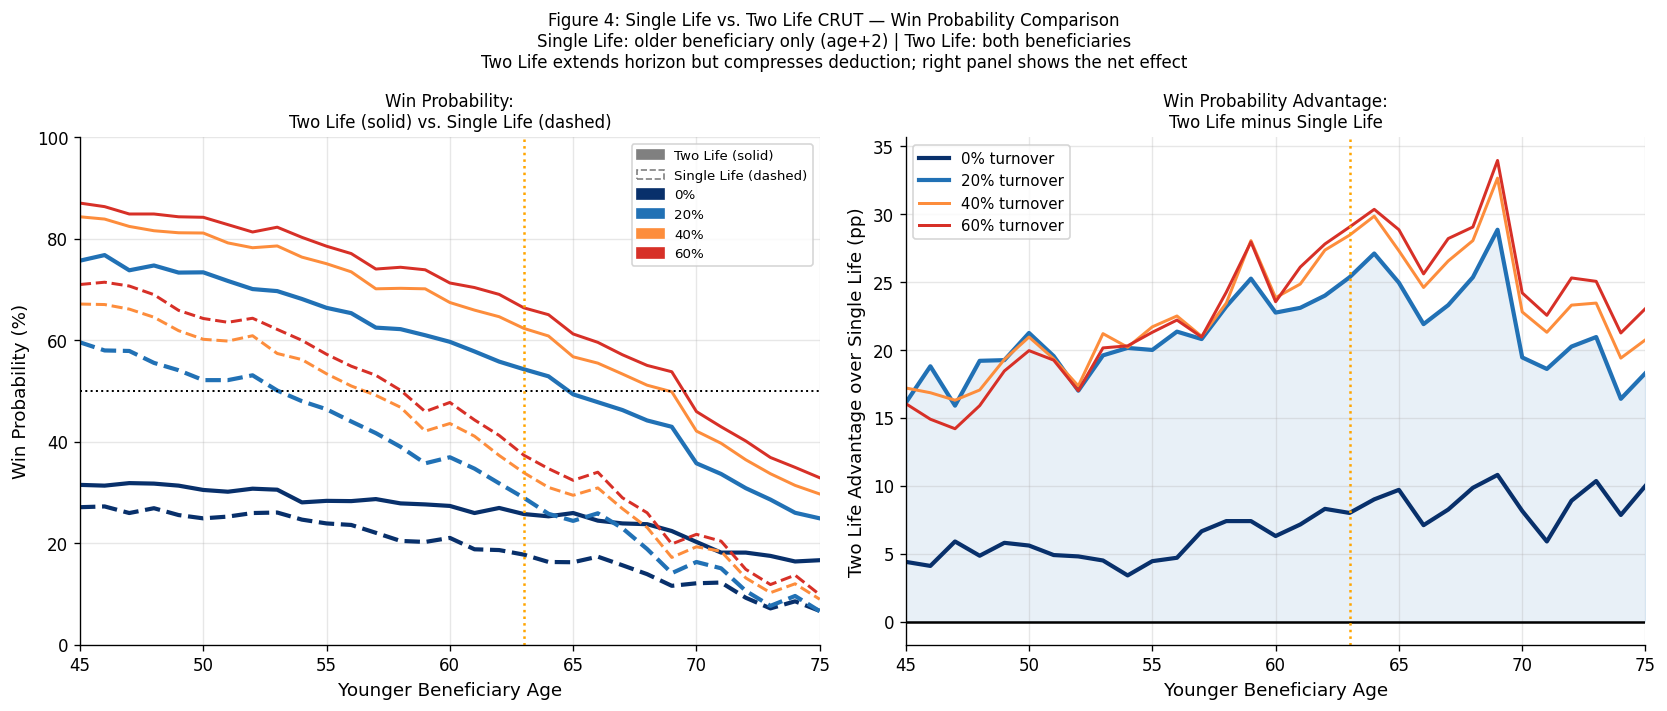

Figure 4 saved.

Deduction comparison at baseline age (63/65):
  Single Life (age 65): $265,996
  Two Life (63/65):     $126,456
  Deduction cost of adding second life: $139,539


In [6]:
# --- Figure 4: Single Life vs. Two Life ---
# Compare at the same donor ages across the age range.
# Single Life uses the older beneficiary (age+2) as the measuring life.

print('Running Single Life vs. Two Life comparison...')

sl_wp   = {tv: [] for tv in TURNOVER_LEVELS}
tl_wp   = {tv: [] for tv in TURNOVER_LEVELS}
sl_deds = []
tl_deds = []

for age in younger_ages:
    for tv in TURNOVER_LEVELS:
        # Single Life on older beneficiary
        r_sl = run_simulation(replace(baseline,
                                      life_type='Single Life',
                                      age1=int(age+2),
                                      age2=None,
                                      turnover=tv))
        # Two Life
        r_tl = run_simulation(replace(baseline,
                                      life_type='Two Life',
                                      age1=int(age),
                                      age2=int(age+2),
                                      turnover=tv))
        sl_wp[tv].append(r_sl['win_prob'])
        tl_wp[tv].append(r_tl['win_prob'])
        if tv == TURNOVER_LEVELS[0]:
            sl_deds.append(r_sl['deduction'])
            tl_deds.append(r_tl['deduction'])

for tv in TURNOVER_LEVELS:
    sl_wp[tv] = np.array(sl_wp[tv])
    tl_wp[tv] = np.array(tl_wp[tv])
sl_deds = np.array(sl_deds)
tl_deds = np.array(tl_deds)
print('Done.')

# Figure 4: Win probability comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
for tv, color, lw in zip(TURNOVER_LEVELS, TURNOVER_COLORS, [2.5,2.5,1.8,1.8]):
    ax.plot(younger_ages, sl_wp[tv]*100, color=color, lw=lw, ls='--')
    ax.plot(younger_ages, tl_wp[tv]*100, color=color, lw=lw, ls='-')

ax.axhline(50, color='black', lw=1.2, ls=':')
ax.axvline(63, color='orange', lw=1.5, ls=':', label='Baseline age (63/65)')
solid_patch = mpatches.Patch(color='gray', label='Two Life (solid)')
dash_patch  = mpatches.Patch(color='gray', linestyle='--',
                              label='Single Life (dashed)', fill=False)
tv_patches = [mpatches.Patch(color=c, label=f'{tv*100:.0f}%')
              for tv, c in zip(TURNOVER_LEVELS, TURNOVER_COLORS)]
ax.legend(handles=[solid_patch, dash_patch] + tv_patches, fontsize=8)
ax.set_xlabel('Younger Beneficiary Age', fontsize=11)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_title('Win Probability:\nTwo Life (solid) vs. Single Life (dashed)', fontsize=10)
ax.set_xlim(45, 75)
ax.set_ylim(0, 100)

# Right panel: win probability advantage of Two Life over Single Life
ax2 = axes[1]
for tv, color, lw in zip(TURNOVER_LEVELS, TURNOVER_COLORS, [2.5,2.5,1.8,1.8]):
    advantage = (tl_wp[tv] - sl_wp[tv]) * 100
    ax2.plot(younger_ages, advantage, color=color, lw=lw,
             label=f'{tv*100:.0f}% turnover')
ax2.axhline(0, color='black', lw=1.5)
ax2.axvline(63, color='orange', lw=1.5, ls=':')
ax2.fill_between(younger_ages,
                  (tl_wp[0.20] - sl_wp[0.20])*100,
                  0,
                  where=(tl_wp[0.20] >= sl_wp[0.20]),
                  alpha=0.1, color='#2171b5')
ax2.set_xlabel('Younger Beneficiary Age', fontsize=11)
ax2.set_ylabel('Two Life Advantage over Single Life (pp)', fontsize=11)
ax2.set_title('Win Probability Advantage:\nTwo Life minus Single Life', fontsize=10)
ax2.legend(fontsize=9)
ax2.set_xlim(45, 75)

fig.suptitle(
    'Figure 4: Single Life vs. Two Life CRUT — Win Probability Comparison\n'
    'Single Life: older beneficiary only (age+2) | Two Life: both beneficiaries\n'
    'Two Life extends horizon but compresses deduction; right panel shows the net effect',
    fontsize=10
)
plt.tight_layout()
plt.savefig('fig4_single_vs_two_life.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 4 saved.')

# Deduction comparison
print()
print('Deduction comparison at baseline age (63/65):')
idx63 = np.argmin(np.abs(younger_ages - 63))
print(f'  Single Life (age 65): ${sl_deds[idx63]:,.0f}')
print(f'  Two Life (63/65):     ${tl_deds[idx63]:,.0f}')
print(f'  Deduction cost of adding second life: ${sl_deds[idx63]-tl_deds[idx63]:,.0f}')

---
## Section 4 — Longevity × Return Interaction

### Figure 5: 2D Heatmap — Longevity Adjustment × Expected Return

Longevity ranked #2 and expected return ranked #1 in the OAT sensitivity analysis. A natural question is whether their effects are **additive** (each parameter independently shifts win probability and the heatmap is a simple gradient) or **interactive** (the effect of longevity depends on the level of return, producing a curved or non-parallel contour pattern).

**Economic basis for interaction:**
At high expected returns, the benchmark's compounding advantage over the CRUT increases with each additional year (because the benchmark retains its full corpus while the CRUT pays out). This means that at high μ, a longer horizon *hurts* the CRUT more than at low μ — or equivalently, the win probability benefit of longer life is reduced when returns are high.

At low expected returns, the benchmark's compounding advantage is modest. Additional years of turnover drag accumulate, and the CRUT's fixed deduction benefit represents a larger fraction of total wealth. In this regime, longer life genuinely helps the CRUT more.

**The heatmap 50% contour shape reveals the nature of this interaction.** A straight diagonal contour means additive effects. A curved contour — bowing toward high-longevity/low-return or low-longevity/high-return — reveals a meaningful interaction term.

Running longevity x return heatmap (264 simulations)...
  3/11 longevity levels complete
  6/11 longevity levels complete
  9/11 longevity levels complete


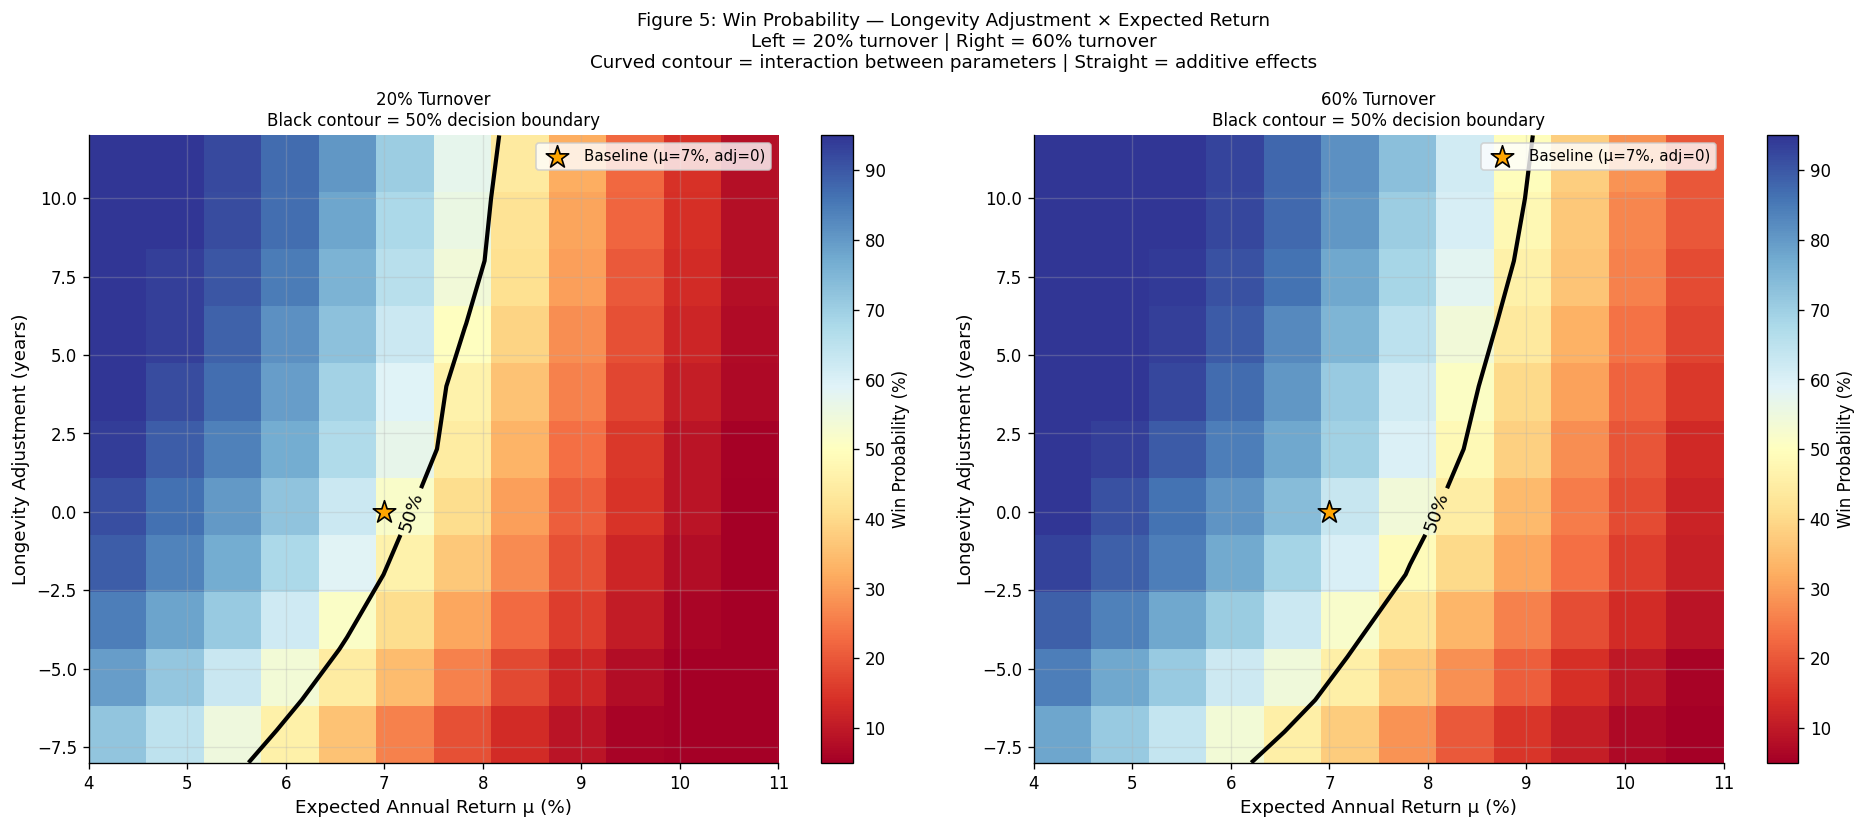

Figure 5 saved.


In [7]:
# --- Figure 5: Longevity x Return interaction heatmap ---

longevity_grid = np.arange(-8, 14, 2)    # -8yr to +12yr in 2yr steps
mu_grid        = np.linspace(0.04, 0.11, 12)  # 4% to 11%

heatmap_20 = np.zeros((len(longevity_grid), len(mu_grid)))  # 20% turnover
heatmap_60 = np.zeros((len(longevity_grid), len(mu_grid)))  # 60% turnover

total = len(longevity_grid) * len(mu_grid) * 2
print(f'Running longevity x return heatmap ({total} simulations)...')

for i, adj in enumerate(longevity_grid):
    for j, mu in enumerate(mu_grid):
        r20 = run_simulation(replace(baseline, longevity_adj=int(adj), mu=mu, turnover=0.20))
        r60 = run_simulation(replace(baseline, longevity_adj=int(adj), mu=mu, turnover=0.60))
        heatmap_20[i, j] = r20['win_prob']
        heatmap_60[i, j] = r60['win_prob']
    if (i+1) % 3 == 0:
        print(f'  {i+1}/{len(longevity_grid)} longevity levels complete')

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, hm, tv_label in [
    (axes[0], heatmap_20, '20% Turnover'),
    (axes[1], heatmap_60, '60% Turnover'),
]:
    im = ax.imshow(
        hm * 100, origin='lower', aspect='auto',
        extent=[mu_grid[0]*100, mu_grid[-1]*100,
                longevity_grid[0], longevity_grid[-1]],
        cmap='RdYlBu', vmin=5, vmax=95
    )
    plt.colorbar(im, ax=ax, label='Win Probability (%)')

    m_g, l_g = np.meshgrid(mu_grid*100, longevity_grid)
    cs = ax.contour(m_g, l_g, hm*100, levels=[50],
                    colors='black', linewidths=2.5)
    ax.clabel(cs, fmt='50%%', fontsize=11)

    ax.scatter([7], [0], color='orange', s=200, marker='*',
               zorder=5, edgecolors='black',
               label='Baseline (μ=7%, adj=0)')
    ax.set_xlabel('Expected Annual Return μ (%)', fontsize=11)
    ax.set_ylabel('Longevity Adjustment (years)', fontsize=11)
    ax.set_title(f'{tv_label}\nBlack contour = 50% decision boundary', fontsize=10)
    ax.legend(fontsize=9)

fig.suptitle(
    'Figure 5: Win Probability — Longevity Adjustment × Expected Return\n'
    'Left = 20% turnover | Right = 60% turnover\n'
    'Curved contour = interaction between parameters | Straight = additive effects',
    fontsize=11
)
plt.tight_layout()
plt.savefig('fig5_longevity_return_heatmap.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure 5 saved.')

---
## Section 5 — Planning Scenarios: Four Archetypal Clients

### Figure 6: Win Probability Summary — Four Client Profiles

This section synthesizes the longevity analysis into a practical planning framework using four archetypal client profiles. Each profile represents a commonly encountered planning situation:

| Profile | Ages | Longevity adj | Rationale |
|---|---|---|---|
| **Young couple** | 50/52 | 0 yr | Pre-retirement, typical health |
| **Baseline couple** | 63/65 | 0 yr | Manuscript baseline — pre-retirement, typical health |
| **Older couple** | 70/72 | 0 yr | Early retirement, seeking income |
| **Healthy baseline** | 63/65 | +7 yr | Baseline ages, above-average health and family longevity |

The healthy baseline profile (+7 yr adjustment) represents a client at the baseline ages whose health status and family history suggest above-average longevity. A 7-year positive adjustment is consistent with the literature on annuitant mortality improvements relative to general population tables.

**Note on the healthy baseline profile:** The +7yr adjustment is presented as a planning scenario — a sensitivity test of what happens if the client lives longer than the IRS tables predict. It is not a representation that CRUT donors as a population are systematically healthier, nor a recommendation to assume longer life in financial projections. Planners should use the no-adjustment baseline as the primary reference and the +7yr scenario as an upside sensitivity check.

Running four client profiles...
  Young couple (50/52, 0yr adj): done
  Baseline couple (63/65, 0yr adj): done
  Older couple (70/72, 0yr adj): done
  Healthy baseline (63/65, +7yr adj): done


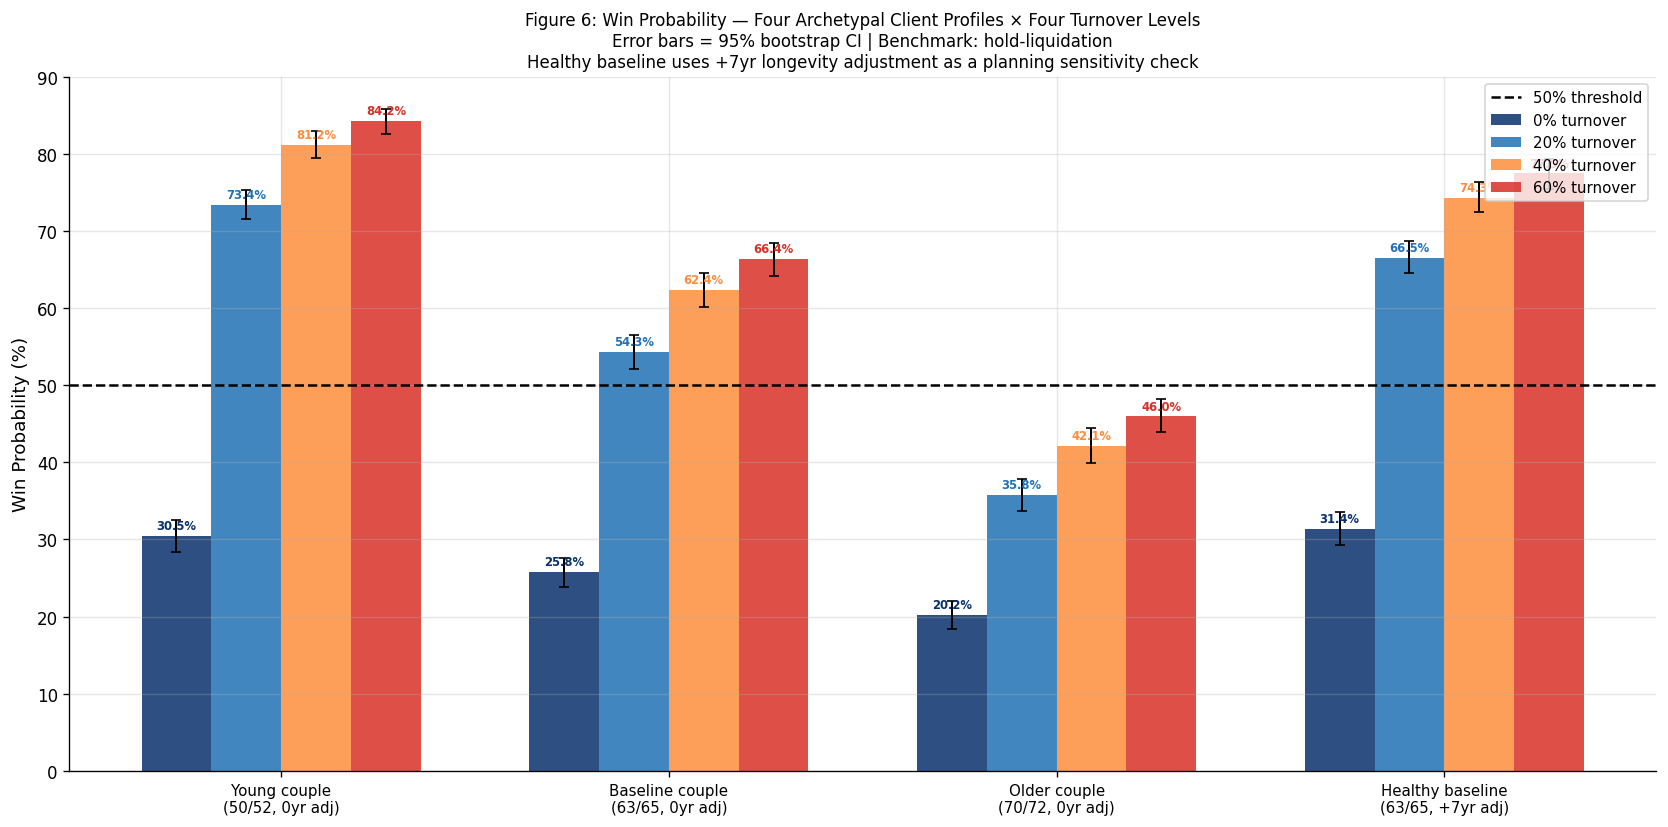


Client profile summary at 20% turnover:
Profile                         Win prob     Median $  Horizon    Deduction
----------------------------------------------------------------------------
Young couple (50/52, 0yr adj)      73.4%  $   120,598      50 yr  $    42,904
Baseline couple (63/65, 0yr adj)     54.3%  $    19,397      33 yr  $   126,456
Older couple (70/72, 0yr adj)      35.8%  $   -56,301      24 yr  $   214,768
Healthy baseline (63/65, +7yr adj)     66.5%  $    83,913      40 yr  $   126,456
Figure 6 saved.


In [8]:
# --- Figure 6: Four archetypal client profiles ---

CLIENT_PROFILES = [
    {'name': 'Young couple\n(50/52, 0yr adj)',
     'age1': 50, 'age2': 52, 'longevity_adj': 0, 'color': '#08306b'},
    {'name': 'Baseline couple\n(63/65, 0yr adj)',
     'age1': 63, 'age2': 65, 'longevity_adj': 0, 'color': '#2171b5'},
    {'name': 'Older couple\n(70/72, 0yr adj)',
     'age1': 70, 'age2': 72, 'longevity_adj': 0, 'color': '#fd8d3c'},
    {'name': 'Healthy baseline\n(63/65, +7yr adj)',
     'age1': 63, 'age2': 65, 'longevity_adj': 7,  'color': '#1a9641'},
]

print('Running four client profiles...')
profile_results = []
for cp in CLIENT_PROFILES:
    tv_wps = []
    for tv in TURNOVER_LEVELS:
        p = replace(baseline,
                    age1=cp['age1'], age2=cp['age2'],
                    longevity_adj=cp['longevity_adj'],
                    turnover=tv)
        r = run_simulation(p)
        lo, hi = bootstrap_ci(r['delta_wealth'])
        tv_wps.append({'win': r['win_prob'], 'lo': lo, 'hi': hi,
                       'med': r['median_delta'], 'T': r['T'],
                       'ded': r['deduction']})
    profile_results.append(tv_wps)
    print(f"  {cp['name'].replace(chr(10), ' ')}: done")

# Figure 6: Grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))
n_profiles = len(CLIENT_PROFILES)
n_tv       = len(TURNOVER_LEVELS)
width      = 0.18
x          = np.arange(n_profiles)
offsets    = np.linspace(-(n_tv-1)/2 * width, (n_tv-1)/2 * width, n_tv)

for ti, (tv, tv_color, offset) in enumerate(zip(TURNOVER_LEVELS, TURNOVER_COLORS, offsets)):
    wp_vals  = [profile_results[pi][ti]['win'] * 100  for pi in range(n_profiles)]
    err_lo   = [wp_vals[pi]/100 - profile_results[pi][ti]['lo'] for pi in range(n_profiles)]
    err_hi   = [profile_results[pi][ti]['hi'] - wp_vals[pi]/100 for pi in range(n_profiles)]
    bars     = ax.bar(x + offset, wp_vals, width,
                      color=tv_color, alpha=0.85,
                      label=f'{tv*100:.0f}% turnover')
    ax.errorbar(x + offset, wp_vals,
                yerr=[np.array(err_lo)*100, np.array(err_hi)*100],
                fmt='none', color='black', capsize=3, lw=1.2)
    for bar, val in zip(bars, wp_vals):
        ax.text(bar.get_x() + bar.get_width()/2, val + 0.5,
                f'{val:.1f}%', ha='center', va='bottom',
                fontsize=7, fontweight='bold', color=tv_color)

ax.axhline(50, color='black', lw=1.5, ls='--', label='50% threshold')
ax.set_xticks(x)
ax.set_xticklabels([cp['name'] for cp in CLIENT_PROFILES], fontsize=9)
ax.set_ylabel('Win Probability (%)', fontsize=11)
ax.set_ylim(0, 90)
ax.set_title(
    'Figure 6: Win Probability — Four Archetypal Client Profiles × Four Turnover Levels\n'
    'Error bars = 95% bootstrap CI | Benchmark: hold-liquidation\n'
    'Healthy baseline uses +7yr longevity adjustment as a planning sensitivity check',
    fontsize=10
)
ax.legend(fontsize=9, loc='upper right')
plt.tight_layout()
plt.savefig('fig6_client_profiles.png', bbox_inches='tight', dpi=150)
plt.show()

# Print summary table
print()
print('Client profile summary at 20% turnover:')
print(f'{"Profile":<30} {"Win prob":>9} {"Median $":>12} {"Horizon":>8} {"Deduction":>12}')
print('-' * 76)
ti_20 = TURNOVER_LEVELS.index(0.20)
for cp, tvr in zip(CLIENT_PROFILES, profile_results):
    name_flat = cp['name'].replace('\n', ' ')
    r = tvr[ti_20]
    print(f'{name_flat:<30} {r["win"]*100:>8.1f}%  '
          f'${r["med"]:>10,.0f}  {r["T"]:>6} yr  ${r["ded"]:>10,.0f}')
print('Figure 6 saved.')

In [9]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print('=' * 65)
print('NOTEBOOK 03 — LONGEVITY: KEY FINDINGS')
print('=' * 65)
print()
print('1. Longevity adjustment sweep (Figure 1):')
idx0 = np.argmin(np.abs(longevity_adjs - 0))
idx_m5 = np.argmin(np.abs(longevity_adjs - (-5)))
idx_p10 = np.argmin(np.abs(longevity_adjs - 10))
for tv, tv_label in zip([0.20, 0.60], ['20% turnover', '60% turnover']):
    wp = longevity_results[tv]
    print(f'   {tv_label}:')
    print(f'     -5yr adj: {wp[idx_m5]:.1%}  |  0yr adj: {wp[idx0]:.1%}  |  +10yr adj: {wp[idx_p10]:.1%}')
    print(f'     OAT range (-5 to +10): {(wp[idx_p10]-wp[idx_m5])*100:.1f} pp  (NB01 reported 39.0 pp)')
print()
print('2. Optimal starting age (20% turnover):')
opt_idx = np.argmax(age_wp[0.20])
print(f'   Ages {younger_ages[opt_idx]}/{younger_ages[opt_idx]+2}: '
      f'win prob = {age_wp[0.20][opt_idx]:.1%}')
print()
print('3. Two Life vs. Single Life at baseline (63/65, 20% turnover):')
idx63 = np.argmin(np.abs(younger_ages - 63))
print(f'   Single Life (65): {sl_wp[0.20][idx63]:.1%}')
print(f'   Two Life (63/65): {tl_wp[0.20][idx63]:.1%}')
print(f'   Two Life advantage: {(tl_wp[0.20][idx63]-sl_wp[0.20][idx63])*100:+.1f} pp')
print()
print('4. Longevity x Return interaction (Figure 5):')
print('   See heatmap contour shape for interaction assessment.')
print('   A curved 50%% contour indicates a non-additive interaction.')
print()

import os
figures = ['fig1_longevity_sweep.png', 'fig2_age_sweep_wp.png',
           'fig3_age_drivers.png',     'fig4_single_vs_two_life.png',
           'fig5_longevity_return_heatmap.png', 'fig6_client_profiles.png']
print('Figure completion check:')
for f in figures:
    print(f"  {'OK' if os.path.exists(f) else 'MISSING'} {f}")
print()
print('Notebook 03 complete. Proceed to Notebook 04 — Payout Rate and §7520.')

NOTEBOOK 03 — LONGEVITY: KEY FINDINGS

1. Longevity adjustment sweep (Figure 1):
   20% turnover:
     -5yr adj: 40.8%  |  0yr adj: 54.3%  |  +10yr adj: 71.0%
     OAT range (-5 to +10): 30.2 pp  (NB01 reported 39.0 pp)
   60% turnover:
     -5yr adj: 51.9%  |  0yr adj: 66.4%  |  +10yr adj: 82.8%
     OAT range (-5 to +10): 30.9 pp  (NB01 reported 39.0 pp)

2. Optimal starting age (20% turnover):
   Ages 46/48: win prob = 76.8%

3. Two Life vs. Single Life at baseline (63/65, 20% turnover):
   Single Life (65): 28.9%
   Two Life (63/65): 54.3%
   Two Life advantage: +25.4 pp

4. Longevity x Return interaction (Figure 5):
   See heatmap contour shape for interaction assessment.
   A curved 50%% contour indicates a non-additive interaction.

Figure completion check:
  OK fig1_longevity_sweep.png
  OK fig2_age_sweep_wp.png
  OK fig3_age_drivers.png
  OK fig4_single_vs_two_life.png
  OK fig5_longevity_return_heatmap.png
  OK fig6_client_profiles.png

Notebook 03 complete. Proceed to Notebo